# PART3 パラメータをチューニングしてみよう

## おまじない

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

## データの読み込み
- train.csvとtest.csvとsubmit_sample.csvの３つのファイルを読み込みましょう
- それぞれを読み込んだものは変数はtrain, test, sampleに代入しましょう

In [2]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
sample = pd.read_csv('submit_sample.csv', header=None)

## trainから説明変数となるデータを取り出しましょう
- iloc[]を使います
- y以外を説明変数として取り出し、変数trainXに代入しましょう

In [3]:
trainX = train.iloc[:, :-1]
trainX

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
id,,,,,,,,,,,,,,,,
0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other
1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown
2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure
3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure
4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27095,37,blue-collar,married,secondary,no,26661,yes,no,cellular,27,may,345,4,425,0,unknown
27096,35,services,married,secondary,no,42150,yes,no,cellular,27,may,121,1,719,0,unknown
27097,35,services,married,unknown,no,34531,no,no,cellular,28,jun,177,2,121,0,unknown


## trainから目的変数となるデータを取り出しましょう
- yを選択し、変数yに代入しましょう

In [4]:
y = train['y']

## testから説明変数となるデータを取り出しましょう
- testの全てのカラムが説明変数となりますので、copy関数を使って変数testXに代入します

In [5]:
testX = test.copy()

In [6]:
print(trainX.shape)
print(testX.shape)

(27100, 16)
(18050, 16)


In [7]:
trainX['train_test'] = 0
testX['train_test'] = 1
X = pd.concat([trainX, testX])
X.shape

(45150, 17)

In [8]:
train.corr()

,age,balance,day,duration,campaign,pdays,previous,y
age,1.000000,-0.001185,-0.059669,-0.055642,0.037633,0.008551,0.037545,0.086668
balance,-0.001185,1.000000,0.003816,0.003144,-0.001229,0.003018,0.009717,-0.000899
day,-0.059669,0.003816,1.000000,0.134440,-0.060326,-0.000433,-0.048624,-0.011804
duration,-0.055642,0.003144,0.134440,1.000000,-0.094643,0.003804,-0.015184,-0.030313
campaign,0.037633,-0.001229,-0.060326,-0.094643,1.000000,-0.003626,-0.038244,-0.030653
pdays,0.008551,0.003018,-0.000433,0.003804,-0.003626,1.000000,0.002187,-0.000116
previous,0.037545,0.009717,-0.048624,-0.015184,-0.038244,0.002187,1.000000,0.188473
y,0.086668,-0.000899,-0.011804,-0.030313,-0.030653,-0.000116,0.188473,1.000000


In [9]:
train['job'].value_counts()

blue-collar      5957
management       5346
technician       4915
admin.           3187
services         2471
self-employed    1163
entrepreneur     1155
retired          1004
unemployed        795
housemaid         754
student           353
Name: job, dtype: int64

In [10]:
test['job'].value_counts()

blue-collar      4086
management       3527
technician       3213
admin.           2152
services         1721
entrepreneur      729
self-employed     727
retired           657
unemployed        511
housemaid         496
student           230
unknown             1
Name: job, dtype: int64

## データ加工

### ビニング

In [11]:
age_bining = pd.cut(train['age'], [20,30,40,50,60,100])
age_bining

id
0        (30, 40]
1        (20, 30]
2        (30, 40]
3        (30, 40]
4        (40, 50]
           ...   
27095    (30, 40]
27096    (30, 40]
27097    (30, 40]
27098    (20, 30]
27099    (30, 40]
Name: age, Length: 27100, dtype: category
Categories (5, interval[int64]): [(20, 30] < (30, 40] < (40, 50] < (50, 60] < (60, 100]]

In [12]:
pd.crosstab(age_bining, train['y'], margins=True)

y,0,1,All
age,,,
"(20, 30]",4210,462,4672
"(30, 40]",16243,1014,17257
"(40, 50]",2765,297,3062
"(50, 60]",1757,339,2096
"(60, 100]",13,0,13
All,24988,2112,27100


In [13]:
duration_bining = pd.cut(train['duration'], [-1, 100,200,300,400,500,600,700,800,900,1000,5000])
duration_bining

id
0        (100, 200]
1        (100, 200]
2        (300, 400]
3        (600, 700]
4        (100, 200]
            ...    
27095    (300, 400]
27096    (100, 200]
27097    (100, 200]
27098    (100, 200]
27099    (300, 400]
Name: duration, Length: 27100, dtype: category
Categories (11, interval[int64]): [(-1, 100] < (100, 200] < (200, 300] < (300, 400] ... (700, 800] < (800, 900] < (900, 1000] < (1000, 5000]]

In [14]:
X['age_bining'] = pd.cut(X['age'], [20,30,40,50,60,100])
X['duration_bining'] = pd.cut(X['duration'], [-1, 100,200,300,400,500,600,700,800,900,1000,5000])


In [15]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,train_test,age_bining,duration_bining
id,,,,,,,,,,,,,,,,,,,
0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0,"(30, 40]","(100, 200]"
1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,0,"(20, 30]","(100, 200]"
2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0,"(30, 40]","(300, 400]"
3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0,"(30, 40]","(600, 700]"
4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0,"(40, 50]","(100, 200]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,49,self-employed,married,tertiary,no,98357,yes,no,cellular,6,jul,101,2,417,0,failure,1,"(40, 50]","(100, 200]"
18046,34,blue-collar,married,secondary,no,29621,yes,no,cellular,12,may,345,1,815,0,unknown,1,"(30, 40]","(300, 400]"
18047,34,admin.,single,secondary,no,94260,yes,no,unknown,16,may,121,2,370,0,unknown,1,"(30, 40]","(100, 200]"


In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45150 entries, 0 to 18049
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              45150 non-null  int64   
 1   job              45150 non-null  object  
 2   marital          45150 non-null  object  
 3   education        45150 non-null  object  
 4   default          45150 non-null  object  
 5   balance          45150 non-null  int64   
 6   housing          45150 non-null  object  
 7   loan             45150 non-null  object  
 8   contact          45150 non-null  object  
 9   day              45150 non-null  int64   
 10  month            45150 non-null  object  
 11  duration         45150 non-null  int64   
 12  campaign         45150 non-null  int64   
 13  pdays            45150 non-null  int64   
 14  previous         45150 non-null  int64   
 15  poutcome         45150 non-null  object  
 16  train_test       45150 non-null  int64  

## trainXとtestXをダミー変数化しましょう

In [17]:
cols_o = X.select_dtypes(include='object').columns.tolist()
cols_o

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [18]:
X = pd.get_dummies(X)
X

,age,balance,day,duration,campaign,pdays,previous,train_test,job_admin.,job_blue-collar,...,"duration_bining_(100, 200]","duration_bining_(200, 300]","duration_bining_(300, 400]","duration_bining_(400, 500]","duration_bining_(500, 600]","duration_bining_(600, 700]","duration_bining_(700, 800]","duration_bining_(800, 900]","duration_bining_(900, 1000]","duration_bining_(1000, 5000]"
id,,,,,,,,,,,,,,,,,,,,,
0,31,12294,21,101,3,498,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,29,43027,22,158,2,702,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,35,12252,11,351,1,826,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,31,99121,16,658,2,120,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,48,42005,3,177,1,273,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,49,98357,6,101,2,417,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
18046,34,29621,12,345,1,815,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
18047,34,94260,16,121,2,370,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0


In [19]:
# import category_encoders as ce
# ce_ohe = ce.OneHotEncoder(handle_unknown='impute')
# ce_ohe.fit(pd.concat([trainX, testX], axis=0))

# trainX = ce_ohe.transform(trainX)
# testX = ce_ohe.transform(testX)

### Objectだけにするとやはり精度が下がる
# ce_ohe.fit(pd.concat([trainX[cols_o], testX[cols_o]], axis=0))

# trainX = ce_ohe.transform(trainX[cols_o])
# testX = ce_ohe.transform(testX[cols_o])


In [20]:
# trainX

### 相関関係をチェック

In [21]:
corrs = []
_X = X[X['train_test'] == 0].drop(['train_test'], axis=1)
features = _X.columns

# print(features)

for c in features:
#     print(c, _X[c])
    corr = np.corrcoef(_X[c], y)[0, 1]
    corrs.append(corr)
corrs = np.array(corrs)


D:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [24]:
_X['job_unknown'].value_counts()

0    27100
Name: job_unknown, dtype: int64

In [25]:
idx = np.argsort(np.abs(corrs))[::-1]
#重要度上位10を格納
cols = _X.columns.values[idx][:10]
importances = corrs[idx][:10]

print(cols, importances)


['job_unknown' 'poutcome_success' 'previous' 'housing_no' 'housing_yes'
 'month_apr' 'month_mar' 'duration_bining_(300, 400]' 'month_oct'
 'month_may'] [        nan  0.29400639  0.18847302  0.16471042 -0.16471042  0.13239254
  0.12802761 -0.12578569  0.10934865 -0.10600027]


In [52]:
import seaborn as sns
sns.set()

xx = pd.concat([_X, y], axis=1).corr()['y'].abs().sort_values(ascending=False)[1:11]
xx

poutcome_success              0.294006
previous                      0.188473
housing_no                    0.164710
housing_yes                   0.164710
month_apr                     0.132393
month_mar                     0.128028
duration_bining_(300, 400]    0.125786
month_oct                     0.109349
month_may                     0.106000
marital_single                0.095064
Name: y, dtype: float64

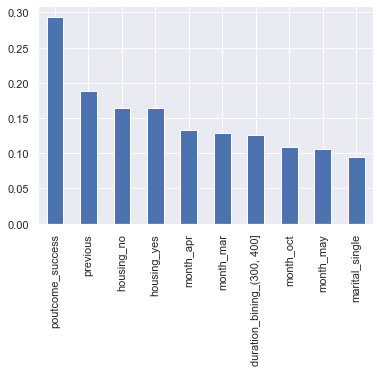

In [53]:
xx.plot.bar()

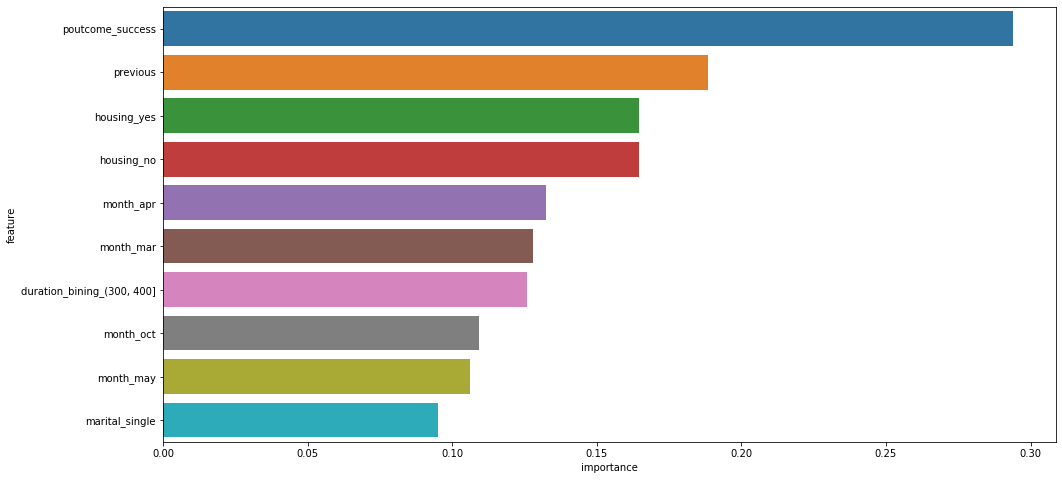

In [29]:
import seaborn as sns

feature_importances = pd.DataFrame()
feature_importances['feature'] = features
feature_importances['importance'] = abs(corrs)
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 8))
sns.barplot(data=feature_importances.head(10), x='importance', y='feature')

In [ ]:
trainX = X[X['train_test'] == 0].drop(['train_test', 'age', 'duration'], axis=1)
testX = X[X['train_test'] == 1].drop(['train_test', 'age', 'duration'], axis=1)

In [ ]:
trainX = X[X['train_test'] == 0].drop(['train_test', 'age', 'duration'], axis=1)
testX = X[X['train_test'] == 1].drop(['train_test', 'age', 'duration'], axis=1)

In [ ]:
trainX.info()

In [ ]:
trainX.shape

In [ ]:
testX.shape

## 決定木モデルの箱を用意しましょう
- 変数名をclf1とし、DT()を代入しましょう
- パラメータは一旦、max_depth=2, min_samples_leaf=500としましょう

In [ ]:
clf1 = DT(max_depth=2, min_samples_leaf=500)

## クロスバリデーションをしてclf1の精度を確かめてみましょう
- cross_validate関数を使います
- オプションには、clf1, trainX, y, cv=5, scoring="roc_auc",n_jobs=-1と書きます

In [ ]:
cross_validate(clf1, trainX, y, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)

## 異なるパラメータでもう一度決定木の箱を準備しましょう
- 変数はclf2としましょう
- パラメータはmax_depth=10, min_samples_leaf=500としましょう

In [ ]:
clf2 = DT(max_depth=10, min_samples_leaf=500)

## クロスバリデーションをしてclf2の精度を確かめてみましょう

In [ ]:
cross_validate(clf2, trainX, y, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)

## 新たな決定木モデルの箱を準備しましょう
- 変数clf3とし、今回は特にパラメータはセットしません

In [ ]:
clf3 = DT()

## グリッドサーチを試してみましょう
- パラメータの範囲を指定し、その範囲をしらみつぶしに調べることで、最適なパラメータを探索することをグリッドサーチといいます
- グリッドサーチ＋クロスバリデーションの組み合わせは良くパラメータ探索の方法として利用されます
- まず探索するパラメータの範囲を表す変数parametersを作ります
- この変数を作る時、"カギ"括弧ではなく、"波"括弧であることに注意して下さい
- {"パラメータの名前①":[範囲], "パラメータの名前②":[範囲]...}のように書きます
- 今回はmax_depthを2から10まで探索してみます

In [ ]:
parameters = {"max_depth":[2,3,4,5,6,7,8,9,10]}

In [ ]:
parameters = {"max_depth": list(range(2,11))}

In [ ]:
parameters

## グリッドサーチ+クロスバリデーションで最適なパラメータを探してみましょう

- GridSearchCV関数を使います
- オプションとして、clf3, parameters, cv=5, scoring="roc_auc",n_jobs=-1と書きます
- グリッドサーチの結果は、変数gcvに代入しましょう
- その後、fit関数を使って、探索をしましょう

In [ ]:
gcv = GridSearchCV(clf3, parameters, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
gcv.fit(trainX, y)

## グリッドサーチの結果を見てみましょう
- cv_____results_で結果を見る事が出来ます

In [ ]:
gcv.cv_results_

## cv_____results_の中で重要な２つをみてみましょう
- cv_____results_["mean_train_score"]とcv_____results_["mean_test_score"]です
- それぞれ変数train_scoreとtest_scoreに代入しましょう

In [ ]:
train_score = gcv.cv_results_['mean_train_score']
test_score = gcv.cv_results_['mean_test_score']

In [ ]:
train_score

## train_scoreとtest_scoreを可視化しましょう
- x軸をmax_depth、y軸をaucとしてグラフを描きます
- 何も設定しないとx軸は0からスタートとなり、実際の値とずれてしまうので、調整が必要です
- 調整をする為には、plt.xticks([0,1],[2,3])のように書きます
- 上記のオプションの意味は何もしない時に0のものを2とし、1のものを3とする、という意味になります
- 今回はmax_depthを2～10まで調べたので9点あります

In [ ]:
plt.plot(train_score)
plt.plot(test_score)
plt.xticks(list(range(0, 10)), list(range(2, 11)))

## グリッドサーチで選ばれたパラメータを確認しましょう
- best_____params_で結果を見ることができます

In [ ]:
gcv.best_params_

## testの予測しましょう
- gcvもpredict_proba関数を持っており、自動的に最適なパラメータを使ったモデルで予測がされます
- 予測結果はpredに代入しましょう。その後、1の確率のみを取り出して、再びpredに代入しましょう

In [ ]:
pred = gcv.predict_proba(testX)

In [ ]:
pred = pred[:,1]

## predをsample[1]に代入してファイル出力し、DeepAnalyticsへ投稿しましょう
- ファイル名は「submit3_bank.csv」としましょう
- index=None,header=Noneのオプションを忘れないように書きだしましょう

In [ ]:
sample[1] = pred
sample.to_csv('submit3_bank.csv', index=None, header=None)

# 実習

1.新たな決定木モデルの箱を変数clf4として準備してみよう。パラメータの設定は不要です

In [ ]:
clf4 = DT()

2.max_depthとmin_samples_leafの値の範囲を指定した変数parameters2を作ろう
- max_depthは2～10まで、min_samples_leafは[5,10,20,50,100,500]にしましょう

In [ ]:
parameters2 = {"max_depth": list(range(2,11)), "min_samples_leaf": [5,10,20,50,100,500]}

3.グリッドサーチ+クロスバリデーションで最適なパラメータを探そう。グリッドサーチの結果は変数gcv2に代入しよう

In [ ]:
gcv2 = GridSearchCV(clf4, parameters2, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
gcv2.fit(trainX, y)

4.最適なパラメータはなんだったか確かめてみよう

In [ ]:
gcv2.best_params_

5.testの予測をし、予測結果のうち、１となる確率のみを変数pred2に代入しよう

In [ ]:
pred2 = gcv2.predict_proba(testX)

In [ ]:
pred2 = pred2[:,1]

6.pred2をsample[1]に代入して"submit4_bank.csv"としてファイル出力し、DeepAnalyticsへ投稿しよう

## LightGBM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score


In [ ]:
# parameters2 = {
#     "max_depth": list(range(2,11)),
#     'num_leaves': list(range(25, 50, 5)),
# }

# lgb = LGBMClassifier()

# gcv3 = GridSearchCV(lgb, parameters2, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)
# gcv3.fit(trainX, y)


In [ ]:
# print(gcv3.best_params_)

# pred3 = gcv3.predict_proba(testX)
# pred3 = pred3[:,1]

# roc_auc_score(y, gcv3.predict_proba(trainX)[:,1])
# # 0.9113408811229391

# # {'max_depth': 5, 'num_leaves': 32}
# # 0.9118745842701466


In [ ]:
lgb = LGBMClassifier(boosting_type='gbdt',  objective='binary', learning_rate=0.1, metric='auc', random_state=0, max_depth=5, num_leaves=32)

In [ ]:
lgb.fit(trainX.values, y)
pred3 = lgb.predict_proba(testX.values)
pred3 = pred3[:,1]

roc_auc_score(y, lgb.predict_proba(trainX)[:,1])
# 0.9118745842701466
